In [2]:
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
import sys
from tqdm import tqdm
from timeit import default_timer as timer

from cmut_nonlinear_sim.mesh import *
from cmut_nonlinear_sim.zmatrix import *


def run_benchmark(mesh, k, **opts):
    
    Z_hm = HierarchicalMatrix(mesh, k, **opts)
    Z_full = FullMatrix(mesh, k)
    b = np.ones(len(mesh.vertices))
    
    # solve full
    start = timer()
    LU = lu(Z_full)
    time_lu_full = timer() - start
    
    start = timer()
    x_full = lusolve(LU, b)
    time_solve_full = timer() - start

    # solve hm by LU
    start = timer()
    LU = lu(Z_hm, eps=1e-12)
    time_lu_hm = timer() - start
    
    start = timer()
    x_hm = lusolve(LU, b)
    time_solve_hm = timer() - start
    
    hm, full, results = {}, {}, {}
    
    hm['size'] = Z_hm.size
    hm['time_assemble'] = Z_hm.assemble_time
    hm['x'] = x_hm
    hm['time_lu'] = time_lu_hm
    hm['time_solve'] = time_solve_hm
    
    full['size'] = Z_full.size
    full['time_assemble'] = Z_full.assemble_time
    full['x'] = x_full
    full['time_lu'] = time_lu_full
    full['time_solve'] = time_solve_full
    
    results['hm'] = hm
    results['full'] = full
    results['nrmse'] = nrmse(x_full, x_hm)
    
    return results


def benchmark(Z):
    
    b = np.ones(Z.shape[0])
    
    # solve full
    start = timer()
    LU = lu(Z, eps=1e-9)
    time_lu = timer() - start
    
    start = timer()
    x = lusolve(LU, b)
    time_solve = timer() - start
    
    results = {}
    results['x'] = x
    results['size'] = Z.size
    results['time_assemble'] = Z.assemble_time
    results['time_lu'] = time_lu
    results['time_solve'] = time_solve
    
    del Z
    
    return results


def nrmse(x, xhat):
    return np.sqrt(np.mean(np.abs(x - xhat) ** 2)) / np.sqrt(np.sum(np.abs(xhat) ** 2))

h2lib initialized


In [3]:
## performance vs. frequency while maintaining mesh size based on wavelength

opts = {}
opts['aprx'] = 'paca'
opts['basis'] = 'linear'
opts['admis'] = 'max'
opts['eta'] = 0.9
opts['eps'] = 1e-12
opts['m'] = 4
opts['clf'] = 32
opts['eps_aca'] = 1e-2
opts['rk'] = 0
opts['q_reg'] = 2
opts['q_sing'] = 4
opts['strict'] = False

c = 1500.
freqs = np.arange(1e6, 50e6 + 1e6, 1e6)

# determine mesh refinement needed at each frequency 
# to maintain maximum edge size less than 10 wavelengths
refns = []
refn = 2
for f in freqs:
    
    wl = c / f

    while True:
        if refn > 20:
            raise Exception
        hmax = square(40e-6, 40e-6, refn=refn).hmax
        if wl / hmax > 10:
            break
        else:
            refn += 1
            
    refns.append(refn)

# benchmark
freq_results = []
for f, refn in tqdm(zip(freqs, refns), total=len(freqs)):
    
    k = 2 * np.pi * f / c
    mesh = fast_matrix_array(5, 5 60e-6, 60e-6, refn=refn, 
                             lengthx=40e-6, lengthy=40e-6)
    
    hm = benchmark(HierarchicalMatrix(mesh, k, **opts))
    full = benchmark(FullMatrix(mesh, k))
    
    results = {}
    results['hm'] = hm
    results['full'] = full
    results['nrmse'] = nrmse(full['x'], hm['x'])
    
    freq_results.append(results)

100%|██████████| 50/50 [04:52<00:00, 20.80s/it]


In [ ]:
## performance vs. mesh size at specific frequency

opts = {}
opts['aprx'] = 'paca'
opts['basis'] = 'linear'
opts['admis'] = 'max'
opts['eta'] = 0.9
opts['eps'] = 1e-12
opts['m'] = 4
opts['clf'] = 32
opts['eps_aca'] = 1e-2
opts['rk'] = 0
opts['q_reg'] = 2
opts['q_sing'] = 4
opts['strict'] = False

c = 1500.
f = 1e6

# determine mesh refinement needed at frequency 
wl = c / f
refn = 2
while True:
    if refn > 20:
        raise Exception
    hmax = square(40e-6, 40e-6, refn=refn).hmax
    if wl / hmax > 10:
        break
    else:
        refn += 1

# benchmark
mesh_results = []
k = 2 * np.pi * f / c
nmax = 20
ram_limit = 4000
refn = 3

for n in tqdm(range(1, nmax, 2)):
    
    mesh = fast_matrix_array(n, n, 60e-6, 60e-6, refn=refn,
                        lengthx=40e-6, lengthy=40e-6)

    hm = benchmark(HierarchicalMatrix(mesh, k, **opts))
    full = benchmark(FullMatrix(mesh, k))

    results = {}
    results['hm'] = hm
    results['full'] = full
    results['nrmse'] = nrmse(full['x'], hm['x'])
    results['vertices'] = len(mesh.vertices)
    results['edges'] = len(mesh.edges)
    results['triangles'] = len(mesh.triangles)
    
    mesh_results.append(results)
    
    if full['size'] > ram_limit:
        print('memory limit reached')
        break

In [ ]:
mesh = fast_matrix_array(4, 4, 60e-6, 60e-6, refn=3, lengthx=40e-6, lengthy=40e-6)
mesh.draw()

Text(0, 0.5, 'Solve time (s)')

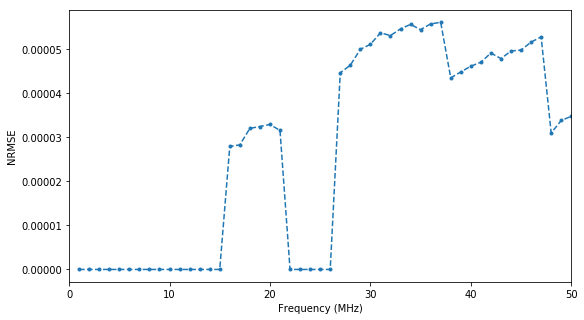

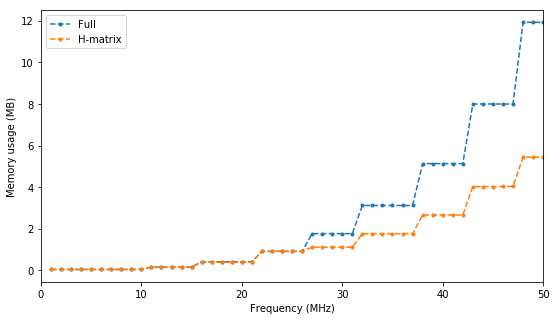

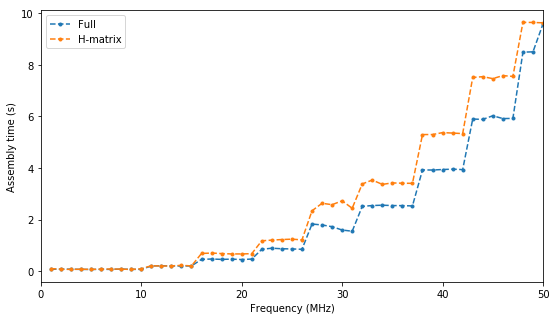

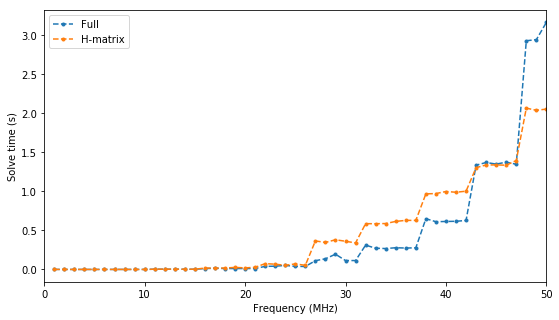

In [4]:
results = freq_results

err = np.array([r['nrmse'] for r in results])
size_hm = np.array([r['hm']['size'] for r in results])
time_assemble_hm = np.array([r['hm']['time_assemble'] for r in results])
time_lu_hm = np.array([r['hm']['time_lu'] for r in results])
time_solve_hm = np.array([r['hm']['time_solve'] for r in results])
size_full = np.array([r['full']['size'] for r in results])
time_assemble_full = np.array([r['full']['time_assemble'] for r in results])
time_lu_full = np.array([r['full']['time_lu'] for r in results])
time_solve_full = np.array([r['full']['time_solve'] for r in results])


fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(freqs / 1e6, err, '.--')
ax.set_xlim(0, freqs.max() / 1e6)
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('NRMSE')

fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(freqs / 1e6, size_full, '.--')
ax.plot(freqs / 1e6, size_hm, '.--')
ax.legend(['Full', 'H-matrix'])
ax.set_xlim(0, freqs.max() / 1e6)
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('Memory usage (MB)')

fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(freqs / 1e6, time_assemble_full, '.--')
ax.plot(freqs / 1e6, time_assemble_hm, '.--')
ax.legend(['Full', 'H-matrix'])
ax.set_xlim(0, freqs.max() / 1e6)
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('Assembly time (s)')

fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(freqs / 1e6, time_lu_full + time_solve_full, '.--')
ax.plot(freqs / 1e6, time_lu_hm + time_solve_hm, '.--')
ax.legend(['Full', 'H-matrix'])
ax.set_xlim(0, freqs.max() / 1e6)
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('Solve time (s)')

In [ ]:
results = mesh_results

err = np.array([r['nrmse'] for r in results])
size_hm = np.array([r['hm']['size'] for r in results])
time_assemble_hm = np.array([r['hm']['time_assemble'] for r in results])
time_lu_hm = np.array([r['hm']['time_lu'] for r in results])
time_solve_hm = np.array([r['hm']['time_solve'] for r in results])
size_full = np.array([r['full']['size'] for r in results])
time_assemble_full = np.array([r['full']['time_assemble'] for r in results])
time_lu_full = np.array([r['full']['time_lu'] for r in results])
time_solve_full = np.array([r['full']['time_solve'] for r in results])
vertices = np.array([r['vertices'] for r in results])

fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(vertices, err, '.--')
ax.set_xlim(0, vertices.max())
ax.set_xlabel('No. of vertices')
ax.set_ylabel('NRMSE')

fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(vertices, size_full, '.--')
ax.plot(vertices, size_hm, '.--')
ax.legend(['Full', 'H-matrix'])
ax.set_xlim(0, vertices.max())
ax.set_xlabel('No. of vertices')
ax.set_ylabel('Memory usage (MB)')

fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(vertices, time_assemble_full, '.--')
ax.plot(vertices, time_assemble_hm, '.--')
ax.legend(['Full', 'H-matrix'])
ax.set_xlim(0, vertices.max())
ax.set_xlabel('No. of vertices')
ax.set_ylabel('Assembly time (s)')

fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(vertices, time_lu_full + time_solve_full, '.--')
ax.plot(vertices, time_lu_hm + time_solve_hm, '.--')
ax.legend(['Full', 'H-matrix'])
ax.set_xlim(0, vertices.max())
ax.set_xlabel('No. of vertices')
ax.set_ylabel('Solve time (s)')

# fig, ax = plt.subplots(figsize=(9, 5))
# plt.plot(vertices, time_lu_full)
# plt.plot(vertices, time_lu_hm)
# plt.legend(['full', 'hm'])

# fig, ax = plt.subplots(figsize=(9, 5))
# plt.plot(vertices, time_solve_full)
# plt.plot(vertices, time_solve_hm)
# plt.legend(['full', 'hm'])

